In [1]:
%matplotlib inline

import sys
sys.path.append('../src/')

import warnings
warnings.filterwarnings('ignore')

import cv2
import torch
import wider_dataset
import choke_point_dataset

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

from benchmark.models import Detector
from benchmark.core import TsvHandle, run_detection, run_detection_video
from benchmark.stats import calc_precision_recall, calc_ap

# https://github.com/serengil/tensorflow-101/blob/master/python/opencv-dnn-face-detection.ipynb
# https://github.com/AyushExel/ml4face-detection/blob/master/Final-Face%20Detection%20Notebook.ipynb

# https://raw.githubusercontent.com/opencv/opencv/4.5.4/samples/dnn/face_detector/deploy.prototxt
# https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

# OpenCV DNN Face Detector based on ResNet-10 Image detection

In [2]:
train, test, validation = tfds.load('wider_dataset', split=['train', 'test', 'validation'])
data = validation

In [3]:
class ResNetDetector(Detector):
    TARGET_SIZE = (300, 300)
    
    CONF_THRESHOLD = 0.5
    NMS_THRESHOLD = 0.4
    
    def __init__(self):
        self.detector = cv2.dnn.readNetFromCaffe("./models/resnet/deploy.prototxt.txt", "./models/resnet/res10_300x300_ssd_iter_140000.caffemodel")
    
    def detect(self, image):
        (h, w) = image.shape[:2]
        blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
            (300, 300), (104.0, 177.0, 123.0))

        self.detector.setInput(blob)
        detections = self.detector.forward()
        
        boxes = []
        confidence = []
        
        for i in range(0, detections.shape[2]):
            conf = detections[0, 0, i, 2]
            if conf > 0.5:
                confidence.append(conf)
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")
                boxes.append([startX, startY, endX, endY])

        return boxes, confidence
    
resnet = ResNetDetector()

In [4]:
with TsvHandle('resnet') as tsv:
    path, ap_path, load_path, meta_path = run_detection(
        tsv_handle = tsv, 
        samples = data, 
        detector = resnet, 
        cv2_filter = cv2.COLOR_RGB2BGR
    )

print("")
print(path)
print(ap_path)
print(load_path)
print(meta_path)

Running detection
[====================] 100% [2/2]
./results/resnet-20220613-164049.tsv
./results/resnet-20220613-164049-ap.tsv
./results/resnet-20220613-164049-load.tsv
./results/resnet-20220613-164049-metadata.tsv


In [5]:
with TsvHandle('resnet_filtered') as tsv:
    path_filtered, ap_path_filtered, load_path_filtered, meta_path_filtered = run_detection(
        tsv_handle = tsv, 
        samples = data, 
        detector = resnet, 
        cv2_filter = cv2.COLOR_RGB2BGR,
        filter_area = 2000
    )

print("")
print(path_filtered)
print(ap_path_filtered)
print(load_path_filtered)
print(meta_path_filtered)

Running detection
[====================] 100% [2/2]
./results/resnet_filtered-20220613-164112.tsv
./results/resnet_filtered-20220613-164112-ap.tsv
./results/resnet_filtered-20220613-164112-load.tsv
./results/resnet_filtered-20220613-164112-metadata.tsv


# Results

In [6]:
df = pd.read_csv(path, sep='\t', header=0, parse_dates=["Timestamp"])
df_filtered = pd.read_csv(path_filtered, sep='\t', header=0, parse_dates=["Timestamp"])

df_ap = pd.read_csv(ap_path, sep='\t', header=0)
df_ap = df_ap.sort_values(by=['Confidence'], ignore_index=True, ascending=False)

df_ap_filtered = pd.read_csv(ap_path_filtered, sep='\t', header=0)
df_ap_filtered = df_ap_filtered.sort_values(by=['Confidence'], ignore_index=True, ascending=False)

df_load = pd.read_csv(load_path, sep='\t', header=0, parse_dates=["Timestamp"])
df_meta = pd.read_csv(meta_path, sep='\t', header=0)

In [7]:
df_meta

,Python,CPU,GPUs
0,3.8.8.final.0 (64 bit),AMD Ryzen 7 2700X Eight-Core Processor,"['device: 0, name: NVIDIA GeForce GTX 1080 Ti,..."


In [8]:
df_load

,Timestamp,CPU_Load,RAM_Avail
0,2022-06-13 16:40:49.206432,9.6,6715768832
1,2022-06-13 16:40:59.777929,20.1,6373355520


In [9]:
def plot_data_over_time(time, data, label):
    plt.plot(time, data)
    plt.xlabel('Time') 
    plt.ylabel(label)
    plt.grid(True)
    plt.show()

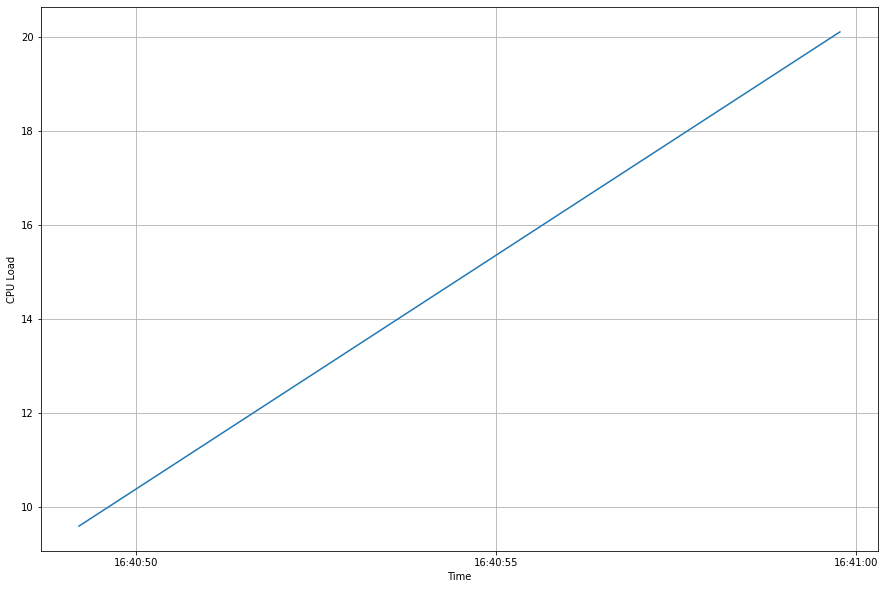

In [10]:
plot_data_over_time(df_load['Timestamp'], df_load['CPU_Load'], 'CPU Load')

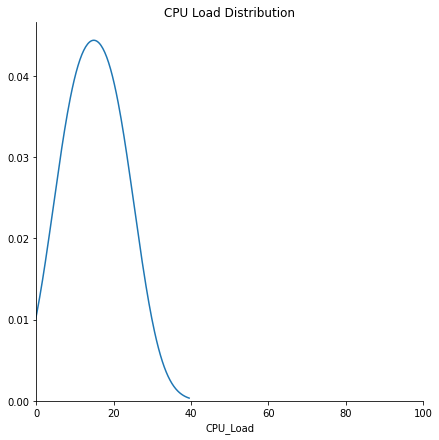

In [11]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'CPU_Load').add_legend()
plt.title('CPU Load Distribution')
plt.xlim(0, 100)
plt.show()

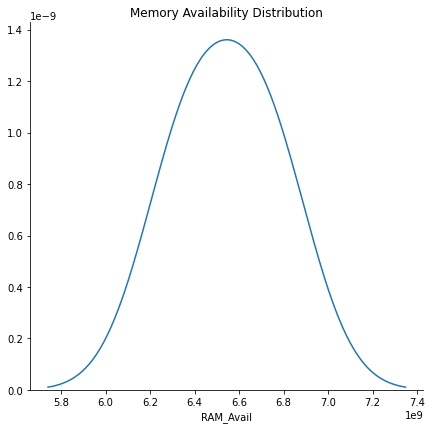

In [12]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'RAM_Avail').add_legend()
plt.title('Memory Availability Distribution')
plt.show()

In [13]:
df

,Timestamp,Speed,Precision,Recall,F1_Score,Ious,Positives,False_Positives,Negatives,Num_Of_Faces,Predicted,Ground_Truth
0,2022-06-13 16:40:49.721428,42191600,1.0,0.75,0.857143,"[0.862749790594711, 0.7594473791141813, 0.8057...",6,0,2,8,"[(785.0, 184.0, 856.0, 293.0), (305.0, 145.0, ...","[(909.0, 335.0, 974.0, 418.0), (786.0, 187.0, ..."
1,2022-06-13 16:40:49.761929,34068400,0.0,0.00,0.000000,[],0,0,1,1,[],"[(547.0, 1228.0, 688.0, 1333.0)]"


In [14]:
df.describe()

,Speed,Precision,Recall,F1_Score,Positives,False_Positives,Negatives,Num_Of_Faces
count,2.000000e+00,2.000000,2.00000,2.000000,2.000000,2.0,2.000000,2.000000
mean,3.813000e+07,0.500000,0.37500,0.428571,3.000000,0.0,1.500000,4.500000
std,5.743970e+06,0.707107,0.53033,0.606092,4.242641,0.0,0.707107,4.949747
min,3.406840e+07,0.000000,0.00000,0.000000,0.000000,0.0,1.000000,1.000000
25%,3.609920e+07,0.250000,0.18750,0.214286,1.500000,0.0,1.250000,2.750000
50%,3.813000e+07,0.500000,0.37500,0.428571,3.000000,0.0,1.500000,4.500000
75%,4.016080e+07,0.750000,0.56250,0.642857,4.500000,0.0,1.750000,6.250000
max,4.219160e+07,1.000000,0.75000,0.857143,6.000000,0.0,2.000000,8.000000


In [15]:
speed = df['Speed'].div(1e6).round(2)
speed.describe()

count     2.000000
mean     38.130000
std       5.741707
min      34.070000
25%      36.100000
50%      38.130000
75%      40.160000
max      42.190000
Name: Speed, dtype: float64

### Generate Precision/Recall columns

In [16]:
all_gts = df['Positives'].sum() + df['Negatives'].sum()
df_ap = calc_precision_recall(df_ap, all_gts)

df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,0.980582,True,True,True,1.0,0.111111,1.0,0.111111,1.000000,0.111111
1,0.956086,True,True,True,1.0,0.222222,1.0,0.222222,1.000000,0.222222
2,0.950841,True,True,True,1.0,0.333333,1.0,0.333333,1.000000,0.333333
3,0.948887,True,True,True,1.0,0.444444,1.0,0.444444,1.000000,0.444444
4,0.926640,True,True,True,1.0,0.555556,1.0,0.555556,1.000000,0.555556
5,0.631522,True,True,False,1.0,0.666667,1.0,0.666667,0.833333,0.555556


In [17]:
all_gts_filtered = df_filtered['Positives'].sum() + df_filtered['Negatives'].sum()
df_ap_filtered = calc_precision_recall(df_ap_filtered, all_gts_filtered)

df_ap_filtered

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,0.980582,True,True,True,1.0,0.111111,1.0,0.111111,1.000000,0.111111
1,0.956086,True,True,True,1.0,0.222222,1.0,0.222222,1.000000,0.222222
2,0.950841,True,True,True,1.0,0.333333,1.0,0.333333,1.000000,0.333333
3,0.948887,True,True,True,1.0,0.444444,1.0,0.444444,1.000000,0.444444
4,0.926640,True,True,True,1.0,0.555556,1.0,0.555556,1.000000,0.555556
5,0.631522,True,True,False,1.0,0.666667,1.0,0.666667,0.833333,0.555556


In [18]:
def plot_pr(df_data, title):
    ap = calc_ap(df_data['Precision@25'], df_data['Recall@25'])
    plt.plot(df_data['Recall@25'], df_data['Precision@25'], color='darkcyan', lw=3, label="AP@0.25=%.2f" % ap)
    plt.axvline(x = df_data['Recall@25'][df_data.index[-1]], ymax=df_data['Precision@25'][df_data.index[-1]], color = 'darkcyan')
    
    ap = calc_ap(df_data['Precision@50'], df_data['Recall@50'])
    plt.plot(df_data['Recall@50'], df_data['Precision@50'], color='darkorange', lw=3, label="AP@0.5=%.2f" % ap)
    plt.axvline(x = df_data['Recall@50'][df_data.index[-1]], ymax=df_data['Precision@50'][df_data.index[-1]], color = 'darkorange')
    
    ap = calc_ap(df_data['Precision@75'], df_data['Recall@75'])
    plt.plot(df_data['Recall@75'], df_data['Precision@75'], color='mediumorchid', lw=3, label="AP@0.75=%.2f" % ap)
    plt.axvline(x = df_data['Recall@75'][df_data.index[-1]], ymax=df_data['Precision@75'][df_data.index[-1]], color = 'mediumorchid')
    
    plt.xlim(0, 1.00)
    plt.ylim(0, 1.00)

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right", prop={'size': 16})
    plt.grid(True)

    plt.show()

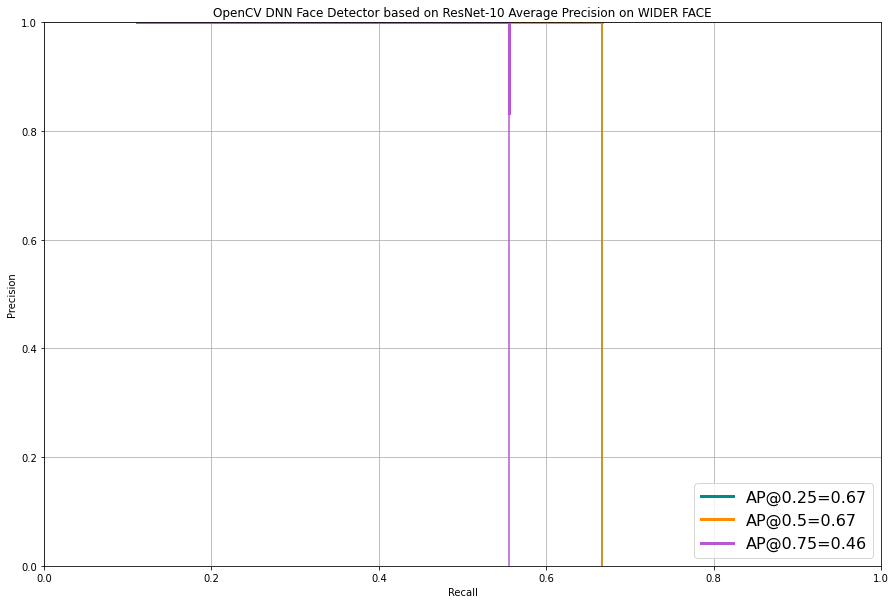

In [19]:
plot_pr(df_ap, 'OpenCV DNN Face Detector based on ResNet-10 Average Precision on WIDER FACE')

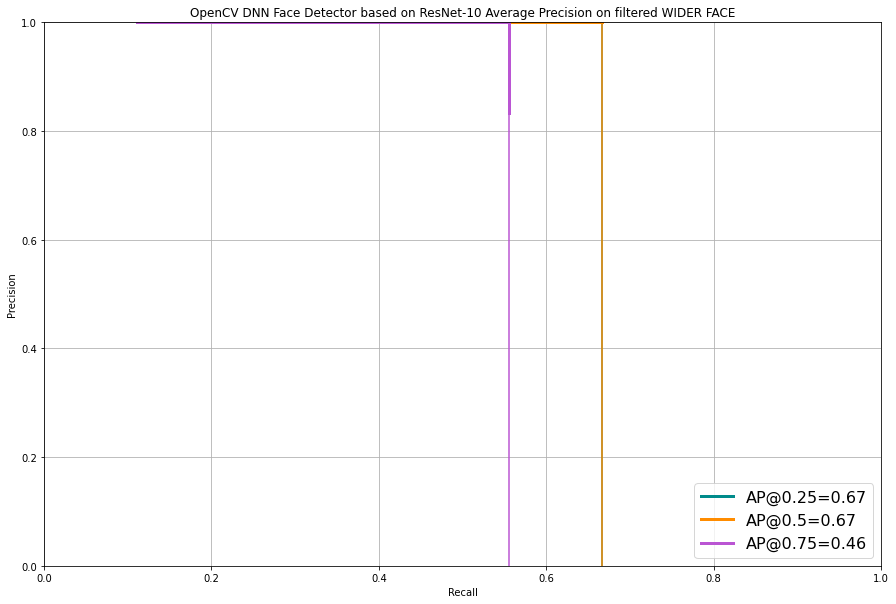

In [20]:
plot_pr(df_ap_filtered, 'OpenCV DNN Face Detector based on ResNet-10 Average Precision on filtered WIDER FACE')

# OpenCV DNN Face Detector based on ResNet-10 Video detection

In [21]:
test = tfds.load('choke_point', split=['test'])

In [22]:
data = test[0]

In [23]:
class ResNetDetector(Detector):
    TARGET_SIZE = (300, 300)
    
    CONF_THRESHOLD = 0.5
    NMS_THRESHOLD = 0.4
    
    def __init__(self):
        self.detector = cv2.dnn.readNetFromCaffe("./models/resnet/deploy.prototxt.txt", "./models/resnet/res10_300x300_ssd_iter_140000.caffemodel")
    
    def detect(self, image):
        (h, w) = image.shape[:2]
        blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
            (300, 300), (104.0, 177.0, 123.0))

        self.detector.setInput(blob)
        detections = self.detector.forward()
        
        boxes = []
        confidence = []
        
        for i in range(0, detections.shape[2]):
            conf = detections[0, 0, i, 2]
            if conf > 0.5:
                confidence.append(conf)
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")
                boxes.append([startX, startY, endX, endY])

        return boxes, confidence
    
resnet = ResNetDetector()

In [24]:
stt_aps, detection_percentages, mean_confidences, mean_inference_times = run_detection_video(
    samples=data, 
    detector=resnet,
    cv2_filter = cv2.COLOR_RGB2BGR,
    results_folder="resnet",
    save_videos=True
)

Frames: [====================] 100% [37/37], Videos: [2/2]

In [25]:
print("Mean Video STT-AP: {0:.2f}".format(np.mean(stt_aps)))
print("Mean detection percentage of faces in all videos: {:.2f}".format(np.mean(detection_percentages)))
print("Mean confidence of boxes in all videos: {:.2f}".format(np.mean(mean_confidences)))
print("Mean inference time for all frames: {:.2f}ms".format(np.mean(mean_inference_times) / 1e+6))

Mean Video STT-AP: 0.67
Mean detection percentage of faces in all videos: 95.56
Mean confidence of boxes in all videos: 0.97
Mean inference time for all frames: 42.35ms
